# Analysing gradient receptive fields of neurons in V4 monkeys

This notebook is about analysing what most strongly activates neurons in V4 and what pixels in an image have to change in order to stimulate the neuron. The gradient RF are calculated for individual images and individual neurons.   

In [1]:
%load_ext autoreload
%autoreload 

import numpy as np
from numpy.linalg import eig
from numpy.linalg import solve
import matplotlib.pyplot as plt
import matplotlib.colors as mat_col
import torch

import nnfabrik
from nnfabrik import builder


import numpy as np
import pickle
import os

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

import nnvision

import datajoint as dj
dj.config['enable_python_native_blobs'] = True


dj.config['database.user']= 'kanderer'
dj.config['database.password']= 'enamel-vendetta-deodorant'


schema_name = 'nnfabrik_monkey_saliency'

schema = dj.schema(schema_name, locals())
dj.config['nnfabrik.schema_name'] = schema_name

from nnfabrik.main import *

Connecting kanderer@134.2.168.16:3306


In [2]:
import datajoint as dj

dj.config['enable_python_native_blobs'] = True

from nnfabrik.templates.trained_model import TrainedModelBase
from nnfabrik.main import *
import os

if not 'stores' in dj.config:
    dj.config['stores'] = {}
    
dj.config['stores']['minio'] = {  # store in s3
    'protocol': 's3',
    'endpoint': os.environ.get('MINIO_ENDPOINT', 'DUMMY_ENDPOINT'),
    'bucket': 'nnfabrik',
    'location': 'dj-store',
    'access_key': os.environ.get('MINIO_ACCESS_KEY', 'FAKEKEY'),
    'secret_key': os.environ.get('MINIO_SECRET_KEY', 'FAKEKEY')
}

In [3]:
basepath = '/data/monkey/toliaslab/CSRF19_V4'
neuronal_data_path = os.path.join(basepath, 'neuronal_data/')
neuronal_data_files = [neuronal_data_path + f for f in listdir(neuronal_data_path) if isfile(join(neuronal_data_path, f))]
image_cache_path = os.path.join(basepath, 'images')

saliency_cache_path = os.path.join(basepath, 'images_saliency')
print(saliency_cache_path)

/data/monkey/toliaslab/CSRF19_V4/images_saliency


In [4]:
@schema
class TrainedModel(TrainedModelBase):
    table_comment = "Trained models"
    storage = "minio"
    model_table = Model
    dataset_table = Dataset
    trainer_table = Trainer
    seed_table = Seed
    user_table = Fabrikant

### Loading a already trained CNN model with a Gaussian readout

In [5]:
key = dict(model_hash='cec63aa4435b2a205ec02eafc0a745ee', dataset_hash='ce98e82c2543a503de7611648340380e', trainer_hash = 'f03a6527ab0422767da50e67e2d543ef')

dataloader, model = (TrainedModel & key).load_model()

In [6]:
model.eval()

Encoder(
  (core): SE2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 32, kernel_size=(15, 15), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4), groups=32, bias=False)
          (out_depth_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          

### Get the best neurons based on test correlation scores

In [7]:
from nnvision.tables.scores import TestCorrelationScore
from nnvision.tables.main import Recording
from nnvision.tables.scores import TestCorrelationScoreEnsemble

In [8]:
#Recording.Units.fetch()

In [9]:
best_five = (Recording.Units*TestCorrelationScore.Units & key).fetch("data_key", "unit_id","unit_index", "unit_test_correlation",limit=5, order_by="unit_test_correlation DESC", as_dict=True)

In [10]:
best_100 = (Recording.Units*TestCorrelationScore.Units & key).fetch("data_key", "unit_id","unit_index", "unit_test_correlation",limit=100, order_by="unit_test_correlation DESC", as_dict=True)#best_5 = (TestCorrelationScore.Units & key).fetch("KEY", "unit_test_correlation", limit=5, order_by="unit_test_correlation DESC")

### Extracting a list of images and the neuron responses:


Extracting the images of the 7 neurons with the best test correlation of session: 3646222772876. 

In [11]:
train_images_session = []
targets_list_session = []


for batch in dataloader["train"]['3646222772876']:
    images = batch.inputs
    responses = batch.targets

    for i in range(0, images.shape[0]):
        train_images_session.append(images[i])
        
        targets_list_session.append(responses[i])
        
print(len(train_images_session))

train_images = train_images_session[:2000]
target_list = targets_list_session[:2000]

12345


In [12]:
#unit indices for the 7 neurons with best test corr

key_list = [{'data_key': '3646222772876', 'unit_index': 3},{'data_key': '3646222772876', 'unit_index': 6},{'data_key': '3646222772876', 'unit_index': 4},{'data_key': '3646222772876', 'unit_index': 0},
            {'data_key': '3646222772876', 'unit_index': 7},{'data_key': '3646222772876', 'unit_index': 1},{'data_key': '3646222772876', 'unit_index': 2}]

len(key_list)

keys = [3,6,4,0,7,1,2]

### Get Gradient receptive fields of the 7 neurons within the same session:

In [ ]:

n_images = len(train_images) # 100 images would also be fine

n_neurons = 7

RFs = torch.zeros(n_neurons, n_images,*train_images[0].shape[1:]) # preallocating RFs

img_x, img_y = train_images[0].shape[1:] # x and y dim on the image

    
#iterates through the 7 neurons with the best test correlation, selects the right session with ['data_key']
j = 0
for best in key_list:
    images = train_images     #taking same images for every neuron 

    for i in range(0, n_images):
        x = images[i].reshape((1,1,images[i].shape[1], images[i].shape[2]))
       
        x = x.clone().detach().requires_grad_(True).to('cpu')
        optimizer = torch.optim.Adam([x], lr = 1.0)
        optimizer.zero_grad()
        
        r = model(x, data_key=best['data_key'], pretrained=True)


        r[0, best['unit_index']].backward(retain_graph=True)
        RFs[j, i] = x.grad.data
    
        x.grad.data.zero_()
    j += 1

In [ ]:
RFs.shape

### Here the reconstructing part is coming

In [ ]:
np_train_images =np.concatenate(train_images, axis=0 )

print(np_train_images.shape)

### PCA idea

In [ ]:
RFs_new = RFs.cpu().detach().numpy()

np_train_images =np.concatenate(train_images, axis=0 )

np_train_images = np.concatenate(train_images_session[0:2000], axis=0)
n_images = 2000

Xpca_list2 = []
components_included = []

# number of components that we want to include for the reconstruction
n_components = 2000


#loop over 7 neurons: RFs_new[i,::] selects receptive fields for a certain neuron 
for i in range(0, 6):
        
    img_flattened = np_train_images.squeeze()

    img_flattened = np.reshape(img_flattened,[n_images,-1])


    rfs_flattened = RFs_new[i,::].squeeze()

    rfs_flattened = np.reshape(rfs_flattened,[n_images,-1])

    # covariance matrix: it's not the kernel matrix because it's of dimension image number * image number, not num of dimension of images themselves

    # subtract mean here
    rfs_flattened = rfs_flattened - rfs_flattened.mean(axis=0, keepdims=True)
    C = rfs_flattened @ rfs_flattened.T  / (rfs_flattened.shape[0]-1)
    uk, u = eig(C)

    uk, u = map(np.real, (uk, u))

    # get the n-most important eigenvectors:
    matrix_v = u[:, 0:n_components]

    #
    V = matrix_v.T @ rfs_flattened
    V = V / np.sqrt( (V**2).sum(axis=1, keepdims=True))

    # V @ V.T where V is containing the n_components largest eigenvectors:
    P = V.T @ V

    #normalize such that every column is equally weighted:

    #P @ image
    Xpca = img_flattened @ P


    #bringing images back in shape
    Xpca = Xpca.reshape((n_images,img_x, img_y)) 
    Xpca_list2.append(Xpca)


In [ ]:
plt.imshow(Xpca[0])

6


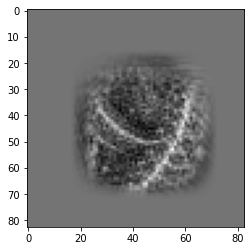

In [66]:
print(len(Xpca_list2))

plt.imshow(Xpca_list2[3][0,:,:], cmap='gray')

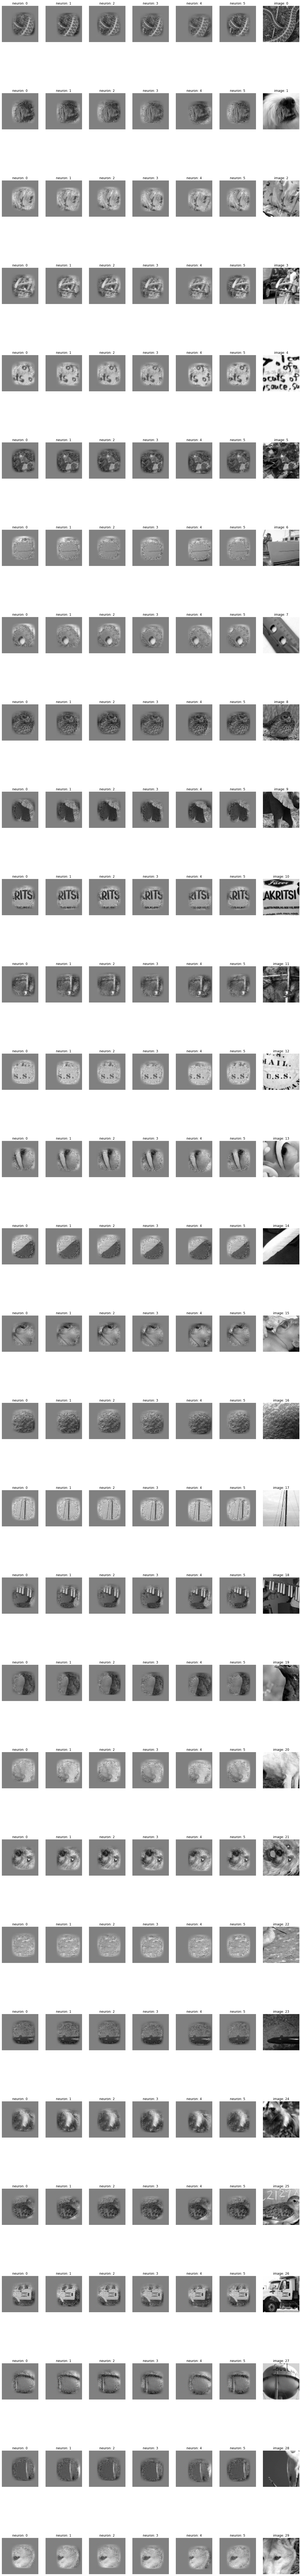

In [67]:
fig, axs = plt.subplots(30, 7, figsize=(20,180))
j = 0 #neuron
i = 0

i = 0
for k in range(0, 30):
   
    for p in range(0, 6):

        max_intensity=np.max(np.abs(Xpca_list2[p][i,:,:]))
        axs[k][p].title.set_text('neuron: ' + str(p))

        axs[k][p].imshow(Xpca_list2[p][i,:,:] ,cmap=  'gray', vmin = -max_intensity, vmax=max_intensity)
        axs[k][p].axis('off')
        

    axs[k][6].title.set_text('image: '+ str(i))
    axs[k][6].imshow(train_images[i].squeeze(0) ,cmap=  'gray')
    axs[k][6].axis('off')
    

    
    i += 1

        
plt.savefig('projection_of_images_with_PCs_of_RFs_500')